# Logistic regression, Lab 2
Made by Louis Dumontet and Victor Serena

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns


<br>

# 1. Data exploration and visualization

In [ ]:
df = pd.read_csv('Dataset/loan_prediction.csv')

In [ ]:
print("Shape of the dataframe :",df.shape)
df.head()

Shape of the dataframe : (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


<br>

## Then we have to check the number of missing values to decide how to deal with them, we will explain our process under each plot

In [ ]:
print("Number of missing values :")
df.isnull().sum()

Number of missing values :


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<br>

## But first the column "Loan_ID" doesn't give us any information, so we'll drop it

In [ ]:
df.drop('Loan_ID', axis=1, inplace=True)

In [ ]:
# function used to show the number of values inside pie plots
def func(percent, nbval):
    
    absolute = int(round(percent/100.*np.sum(nbval)))
    return "{:d}".format(absolute)

<br>

## Before beginning anything let's see how many people get their loans approved

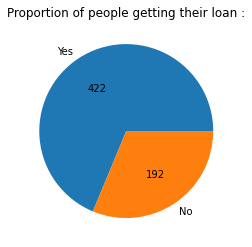

In [ ]:
status_count = df.Loan_Status.value_counts().tolist()

plt.title("Proportion of people getting their loan :")
plt.pie(status_count, labels = ['Yes', 'No'], autopct=lambda pct: func(pct, len(df)))
plt.show()

<br>

## Now we can plot columns with missing values


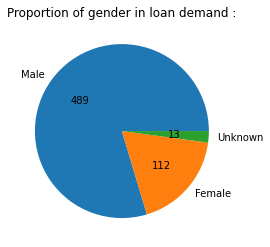

In [ ]:
maskGender = df.Gender == 'Male'

male_count = df[maskGender].shape[0]
female_count = df.shape[0] - male_count - 13

plt.title("Proportion of gender in loan demand :")
plt.pie([male_count, female_count, 13], labels = ['Male', 'Female', 'Unknown'], autopct=lambda pct: func(pct, len(df)))
plt.show()

#### With a proportion such as this we decided to transform the unknows into male
<br>

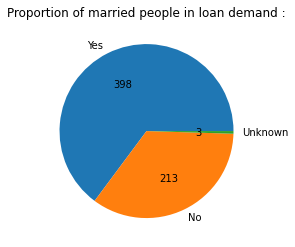

In [ ]:
maskMarried = df.Married == 'Yes'

married_count = df[maskMarried].shape[0]

unmarried_count = df.shape[0] - married_count - 3
all_count=married_count

plt.title("Proportion of married people in loan demand :")
plt.pie([married_count, unmarried_count, 3], labels = ['Yes', 'No', 'Unknown'], autopct=lambda pct: func(pct, len(df.Married)))
plt.show()

#### Because there is such a low unknowns we decided to change them into married people as it won't change too much
<br>

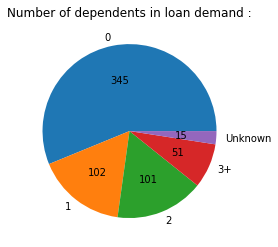

In [ ]:
dependents_count = df.Dependents.value_counts().tolist()
dependents_count.append(15)

plt.title("Number of dependents in loan demand :")
plt.pie(dependents_count, labels = ['0', '1', '2', '3+', 'Unknown'], autopct=lambda pct: func(pct, len(df)))
plt.show()

#### Here it is a little trickier because we have more than 2 categories, but we decided to transform the unknowns into 0 because it is by far the largest chunk of the pie chart
<br>

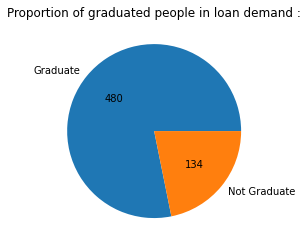

In [ ]:
education_count = df.Education.value_counts().tolist()

plt.title("Proportion of graduated people in loan demand :")
plt.pie(education_count, labels = ['Graduate', 'Not Graduate'], autopct=lambda pct: func(pct, len(df)))
plt.show()

#### No missing value here
<br>

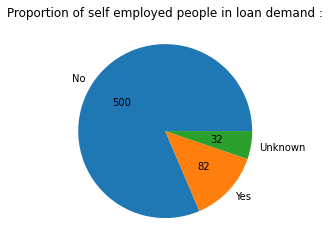

In [ ]:
employed_count = df.Self_Employed.value_counts().tolist()
employed_count.append(32)

plt.title("Proportion of self employed people in loan demand :")
plt.pie(employed_count, labels = ['No', 'Yes', 'Unknown'], autopct=lambda pct: func(pct, len(df)))
plt.show()


#### Here we chose to transform the unknown into No's as they are the vast majority
<br>

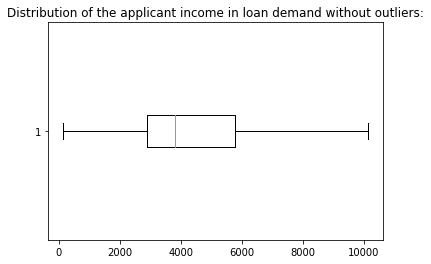

In [ ]:
plt.title("Distribution of the applicant income in loan demand without outliers:")
plt.boxplot(df.ApplicantIncome, vert=False, showfliers=False)
plt.show()

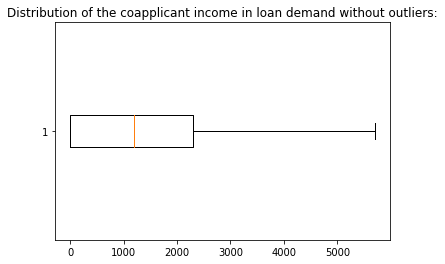

In [ ]:
plt.title("Distribution of the coapplicant income in loan demand without outliers:")
plt.boxplot(df.CoapplicantIncome, vert=False, showfliers=False)
plt.show()

#### It is worth to note that most (almost half) applicant do not have any Coapplicants or a Coapplicant with no income (income = 0)
<br>

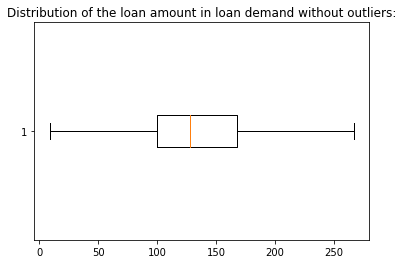

In [ ]:
plt.title("Distribution of the loan amount in loan demand without outliers:")
plt.boxplot(df.LoanAmount.dropna(), vert=False, showfliers=False)
plt.show()


#### Since the loan amount is very important, we chose to remove unknown values

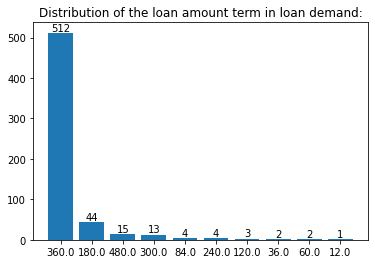

In [ ]:
plt.title("Distribution of the loan amount term in loan demand:")

#get the labels, here they represent the possible values
xlabels = [str(val) for val in df.Loan_Amount_Term.value_counts().index]
#then get the number of occurences of each value
plot_values = list(df.Loan_Amount_Term.value_counts().values)

#plot and annotate the number of occurences on top of each bar
plt.bar(xlabels,plot_values)
for i in range(len(plot_values)):
    plt.annotate(str(plot_values[i]), xy=(xlabels[i],plot_values[i]), ha='center', va='bottom')

plt.show()

#### We can see that most loans are very long term with an overwhelming majority for loans of 30 years (360 months)
<br>

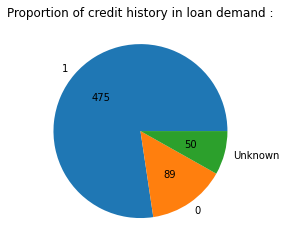

In [ ]:
history_count = df.Credit_History.value_counts().tolist()
history_count.append(50)

plt.title("Proportion of credit history in loan demand :")
plt.pie(history_count, labels = ['1', '0', 'Unknown'], autopct=lambda pct: func(pct, len(df)))
plt.show()

#### Here we chose to transform the unknown into 1's as they are the vast majority
<br>

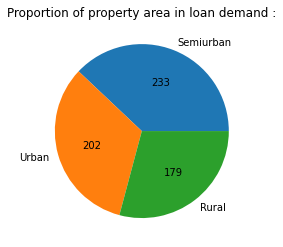

In [ ]:
property_count = df.Property_Area.value_counts().tolist()

plt.title("Proportion of property area in loan demand :")
plt.pie(property_count, labels = ['Semiurban', 'Urban', 'Rural'], autopct=lambda pct: func(pct, len(df)))
plt.show()

#### Here we don't have any missing value
<br>

# 2. Feature engineering

## First, let's deal with missing values

In [ ]:
df.dropna(inplace=True, subset=['LoanAmount'])
df['Gender'].fillna('Male', inplace=True)
df['Dependents'].fillna('0', inplace=True)
df['Married'].fillna('Yes', inplace=True)
df['Self_Employed'].fillna('No', inplace=True)
df['Loan_Amount_Term'].fillna(360, inplace=True)
df['Credit_History'].fillna('1.0', inplace=True)

#### Each of the column has been filled as explained under their plot aforshown
<br>

In [ ]:
print("Number of missing values :")
df.isnull().sum()

Number of missing values :


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

#### We can indeed see that we now have no missing values
<br>

## Let's now normalize our data

In [ ]:
to_normalize = df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']]

to_normalize = (to_normalize - to_normalize.mean()) / to_normalize.std()

df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']] = to_normalize

## Thus, let's move to one hot encoding

In [ ]:
df = pd.get_dummies(df, columns=['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area'])
df.replace({'Loan_Status' : {'Y':1, 'N':0}} , inplace=True)

## Here is our data after feature engineering

In [ ]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,-0.133240,-0.045366,-0.215127,0.269354,0,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
2,-0.390051,-0.553501,-0.939534,0.269354,1,0,1,0,1,1,...,1,0,0,1,0,1,0,0,0,1
3,-0.457701,0.241049,-0.308599,0.269354,1,0,1,0,1,1,...,0,1,1,0,0,1,0,0,0,1
4,0.096640,-0.553501,-0.063236,0.269354,1,0,1,1,0,1,...,1,0,1,0,0,1,0,0,0,1
5,0.002060,0.860381,1.408945,0.269354,1,0,1,0,1,0,...,1,0,0,1,0,1,0,0,0,1


# 3. Model

In [ ]:
def split(dataframe, test_size = 0.2) :
    
    """Split the dataframe in train and test"""
    
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    
    size = dataframe.shape[0]
    
    # train size is size of the (1-test_size)*100 percent of the dataframe that was sampled before
    train_size = int(size * (1 - test_size))
    
    train = dataframe[:train_size]
    
    test = dataframe[train_size:]
    
    return train, test

In [ ]:
def weights_initializer(dataframe):
    
    """Creation of the weight vector according to the size of the dataset"""
    
    # we initialized our weights to 0
    weights = np.zeros((dataframe.shape[1],1))
    
    return weights

In [ ]:
def create_matrix(dataframe, column) : 
    
    """Creation of the matrix of observations from a dataframe"""
    
    # drop the label colum that we want to predict
    df_without_column = dataframe.drop(column, axis=1)
    
    matrix = df_without_column.to_numpy()
    
    # add the bias column to the dataset
    matrix = np.c_[np.ones(matrix.shape[0]), matrix]
    
    return matrix

In [ ]:
def create_labels(dataframe, column) :
    
    """Creation of the labels vector"""
    
    # .T allow us to return a column and not a row containing all the values
    labels = dataframe[column].to_numpy().T
    
    labels.shape = (dataframe.shape[0], 1)
    
    return labels

In [ ]:
def sigmoid(x) :

    """Compute the sigmoid of a number, vector or matrix"""

    return 1 / (1 + np.exp(-x) )

In [ ]:
def cost_function(matrix, weights, labels) :
    
    """Compute the cost function"""
    
    m = matrix.shape[0]
    
    # this is the computation of the cost function using matrix multiplication
    J = - np.sum( labels * np.log( sigmoid(matrix @ weights)) + (1 - labels) * np.log(1 - sigmoid(matrix @ weights))) / m
    
    return J

In [ ]:
def gradient_descent(matrix, weights, labels, learning_rate = 0.03):
    
    """Update and return the weights"""
    
    m = matrix.shape[0]
    
    # compute new weight vector given the learning rate and previous weights
    weights = weights - learning_rate / m * (matrix.T @ ( sigmoid(matrix @ weights) - labels))
    
    return weights

In [ ]:
def logistic_regression(dataframe, labels_column, delta=0, learning_rate = 0.03, iterations = 1000) : 
    
    # cost list that will help us check that our cost is indeed decreasing
    cost_list = []
    
    # intialize everything using the previous functions
    weights = weights_initializer(dataframe)
    
    matrix = create_matrix(dataframe, labels_column)
    
    labels = create_labels(dataframe, labels_column)
    
    cost = cost_function(matrix, weights, labels)
    
    cost_list.append(cost)
    
    # execute the gradient descent, stop when the max number of iterations is reached or when the cost is sufficiently low
    for i in range(iterations - 1) :
        
        weights = gradient_descent(matrix, weights, labels, learning_rate)
        
        new_cost = cost_function(matrix, weights, labels)
        
        cost_list.append(new_cost)
        
        if abs(new_cost - cost) < delta :
            
            break
        
        cost = new_cost
        
    return weights, cost_list

## Now that we have implemented our logistic regression let's run it and check the cost vs iteration curve

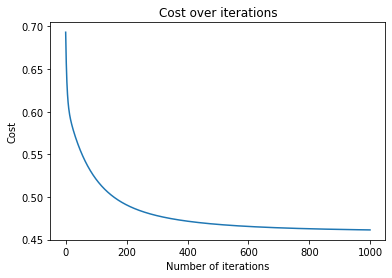

In [ ]:
train, test = split(df, test_size = 0.2)

weights, cost_list = logistic_regression(train, 'Loan_Status', delta=0, learning_rate = 0.1, iterations = 1000)

plt.title("Cost over iterations")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.plot(cost_list)
plt.show()

<br>

## After implementing and running our model, let's explore some metrics

In [ ]:
def get_confusion_matrix_components(dataframe, weights, threshold, labels_column):

    matrix = create_matrix(dataframe, labels_column)
    labels = create_labels(dataframe, labels_column)

    predictions = sigmoid(matrix @ weights)
    mask = predictions > threshold
    predictions = mask.astype(int)

    tp = len((predictions + labels)[predictions + labels == 2])
    fp = len(predictions[predictions== 1]) - tp
    fn = len((labels - predictions)[labels - predictions == 1])
    tn = len(predictions[predictions == 0]) - fn

    return tp, fp, fn, tn, labels, predictions,

In [ ]:
def metrics(dataframe, weights, threshold, labels_column):

    tp, fp, fn, tn, labels, predictions = get_confusion_matrix_components(dataframe,weights,threshold, labels_column)

    precision = tp / (tp + fp) if tp !=0 else 0
    recall = tp / (tp + fn) if tp != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if tp != 0 else 0
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    
    return accuracy, precision, recall, f1

In [ ]:
def plot_metrics(dataframe, weights, labels_column) :

    acc_list, prec_list, recall_list, f1_list = [], [], [], []
    thresholds = [i for i in np.arange(0,1.005,0.005)]

    for i in thresholds:
        accuracy, precision, recall, f1 = metrics(dataframe, weights, i, labels_column)

        acc_list.append(accuracy)
        prec_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    plt.title("Metrics over thresold")
    plt.xlabel("Threshold")
    plt.ylabel("Metrics")
    acc, = plt.plot(thresholds, acc_list)
    prec, = plt.plot(thresholds, prec_list)
    rec, = plt.plot(thresholds, recall_list)
    f, = plt.plot(thresholds, f1_list)
    plt.legend([acc, prec, rec, f], ['Accuracy', 'Precision','Recall', 'F1-score'])

    return acc_list, prec_list, recall_list, f1_list, thresholds

## Let's check how the metrics fare against the thresholds

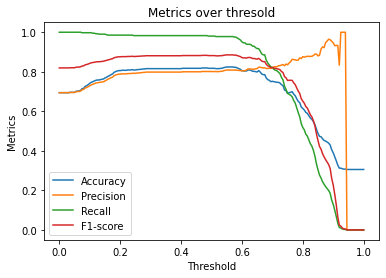

In [ ]:
acc_list, prec_list, recall_list, f1_list, thresholds = plot_metrics(df, weights, 'Loan_Status')

#### We can see that after a certain threshold (~0.95) the metrics crash down dramatically, this is due to the fact that at this high a threshold the model can't find any true positive
<br>

In [ ]:
def argmax(liste) :
    return max((x,i) for i,x in enumerate(liste))[1]

#### We will choose the threshold in order to have the highest F1-score possible

In [ ]:
best_threshold = thresholds[argmax(f1_list)]
print('For the best f1 score it seems the best threshold is',best_threshold)

For the best f1 score it seems the best threshold is 0.5700000000000001


<br>

## Let's take a look at the confusion matrix

In [ ]:
tp, fp, fn, tn, _, _ = get_confusion_matrix_components(df, weights, best_threshold, 'Loan_Status')
cm = pd.DataFrame({ 'Predicted No': [str(tn)+' True Negatives',str(fn)+' False Negatives'],
                    'Predicted Yes': [str(fp)+' False Positives', str(tp)+' True Positives']},
                    index=['Actual No','Actual yes'])


cm

,Predicted No,Predicted Yes
Actual No,86 True Negatives,95 False Positives
Actual yes,9 False Negatives,402 True Positives


<br>

## Now we can check the metrics (i.e. accuracy, precision, recall and F1-score)

In [ ]:
accuracy, precision, recall, f1 = metrics(train, weights, best_threshold, 'Loan_Status')
print("Results on the training set :")
print("Accuracy : "+str(accuracy * 100)+" %")
print("Precision :",precision)
print("Recall :",recall)
print("F1-score :",f1)
print()

accuracy, precision, recall, f1 = metrics(test, weights, best_threshold, 'Loan_Status')
print("Results on the test set :")
print("Accuracy : "+str(accuracy * 100)+" %")
print("Precision :",precision)
print("Recall :",recall)
print("F1-score :",f1)

Results on the training set :
Accuracy : 81.81818181818183 %
Precision : 0.8020304568527918
Recall : 0.9753086419753086
F1-score : 0.8802228412256268

Results on the test set :
Accuracy : 84.87394957983193 %
Precision : 0.8349514563106796
Recall : 0.9885057471264368
F1-score : 0.9052631578947368


<br>

## And let's plot the ROC curve to get the area under it to score our classifier

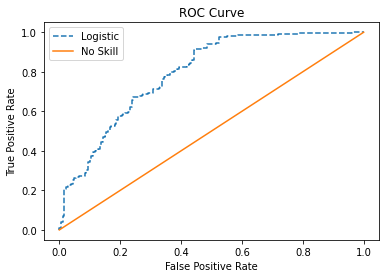

In [ ]:
matrix = create_matrix(df, 'Loan_Status')
labels = create_labels(df, 'Loan_Status')

predictions = sigmoid(matrix @ weights)

base = [i for i in np.arange(0,1.01,0.01)] 

roc_1, roc_2, _ = roc_curve(labels, predictions)
plt.plot(roc_1, roc_2, linestyle='--', label='Logistic')
plt.plot(base, base, label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()

In [ ]:
auc_score = roc_auc_score(labels, predictions)
print("AUC score :",auc_score)

AUC score : 0.7933217727950962


<br>

# 4. Logistic Regression with scikit-learn

In [ ]:
train, test = split(df, test_size = 0.2)

X_train = create_matrix(train, 'Loan_Status')
Y_train = create_labels(train, 'Loan_Status')

X_test = create_matrix(test, 'Loan_Status')
Y_test = create_labels(test, 'Loan_Status')

model = LogisticRegression().fit(X_train, Y_train.ravel())

predictions_train = model.predict(X_train)

predictions_test = model.predict(X_test)

mask = predictions_test > 0.5
predictions_test = np.reshape(mask.astype(int), (mask.astype(int).shape[0], 1))

mask = predictions_train > 0.5
predictions_train = np.reshape(mask.astype(int), (mask.astype(int).shape[0], 1))


<br>

## Lets check the metrics score from scikit-learn

In [ ]:
print("Accuracy of the model on the training set :",model.score(X_train, Y_train) * 100,"%")
print("Precision of the model on the training set :",precision_score(Y_train, predictions_train))
print("Recall of the model on the training set :",recall_score(Y_train, predictions_train))
print("F1-score of the model on the training set :",f1_score(Y_train, predictions_train))
print()

print("Accuracy of the model on the test set :",model.score(X_test, Y_test) * 100,"%")
print("Precision of the model on the test set :",precision_score(Y_test, predictions_test))
print("Recall of the model on the test set :",recall_score(Y_test, predictions_test))
print("F1-score of the model on the test set :",f1_score(Y_test, predictions_test))

Accuracy of the model on the training set : 81.81818181818183 %
Precision of the model on the training set : 0.8029556650246306
Recall of the model on the training set : 0.9819277108433735
F1-score of the model on the training set : 0.8834688346883469

Accuracy of the model on the test set : 78.99159663865547 %
Precision of the model on the test set : 0.77
Recall of the model on the test set : 0.9746835443037974
F1-score of the model on the test set : 0.8603351955307262


#### We can see that our values are very similar to the ones produced from scikit
<br>

## Let's look at the confusion matrix from scikit-learn

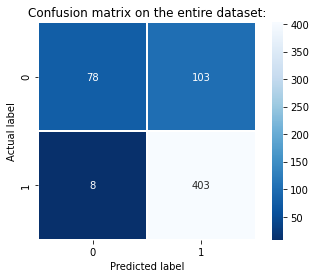

In [ ]:
X = create_matrix(df, 'Loan_Status')
Y = create_labels(df, 'Loan_Status')

predictions = model.predict(X)

cm = confusion_matrix(Y, predictions)

sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix on the entire dataset:");

#### Once again we have very similar values
<br>

In [ ]:
predictions = model.predict_proba(X)
auc_score = roc_auc_score(Y, predictions[:,1:])
print("AUC score :",auc_score)

AUC score : 0.7934158701993521


# Conclusion

#### It seems that our classifier is very similar to the one from scikitlearn, we have nearly the same confusion matrix and just about the same metrics

#### We have the same results in almost every aspects.